## Google’s strongest NLP model: BERT

https://github.com/google-research/bert

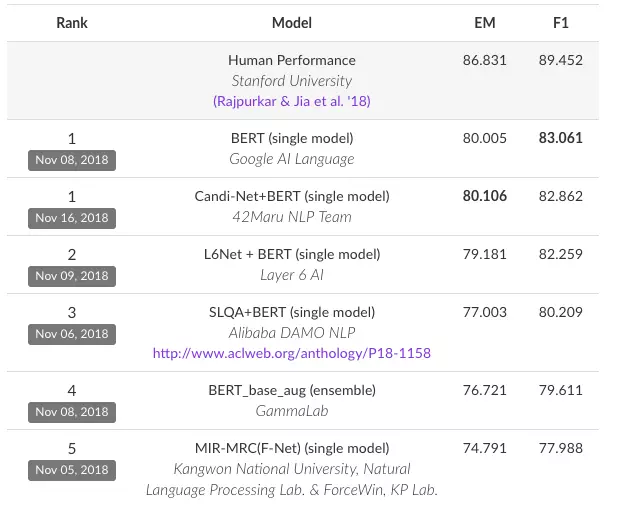
BERT can be used in tasks such as question answering systems, sentiment analysis, spam filtering, named entity recognition, document clustering, etc., as the infrastructure or language model for these tasks.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load Data

In [2]:
data = pd.read_csv('Tweets.csv') 
print('Dataframe:')
data.head(1)

Dataframe:


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)


In [3]:
# Select features
df = data[['text', 'airline_sentiment']]
print('Feature selected DataFrame:')
df.head()

Feature selected DataFrame:


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [4]:
df.shape

(14640, 2)

## Test and Train dataframes

In [5]:
train_df,eval_df = train_test_split(df,test_size = 0.2)

## Building a model

In [8]:
#pip install simpletransformers
from simpletransformers.classification import ClassificationModel
import torch
# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [9]:
def making_label(airline_sentiment):
    if(airline_sentiment=='positive'):
        return 0
    elif(airline_sentiment=='neutral'):
        return 2
    else:
        return 1
    
train_df['label'] = train_df['airline_sentiment'].apply(making_label)
eval_df['label'] = eval_df['airline_sentiment'].apply(making_label)
print(train_df.head())

                                                    text  ... label
11001  @USAirways we already spoke to someone several...  ...     1
1561             @united I need help with a missing bag.  ...     1
2557   @united my flight out of BGM Cancelled Flightl...  ...     1
4148   @united here I was thinking how I could say so...  ...     1
4616   @SouthwestAir 3 hours and 80 degree difference...  ...     0

[5 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
train_df2 = pd.DataFrame({
    'text': train_df['text'].replace(r'\n', ' ', regex=True),
    'label': train_df['label']
})

eval_df2 = pd.DataFrame({
    'text': eval_df['text'].replace(r'\n', ' ', regex=True),
    'label': eval_df['label']
})

In [11]:
model.train_model(train_df2)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:353: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(1464, 0.522169746533596)

In [12]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df2)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:851: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


## Model Evaluation

In [13]:
print(result)
print(model_outputs)
#print(wrong_predictions)

{'mcc': 0.6898161979010954, 'eval_loss': 0.4371291710053637}
[[-3.34957337  2.45363379 -1.35096169]
 [-2.83464003  3.16320467 -2.11451244]
 [-3.41498327  2.94220018 -1.60261059]
 ...
 [-2.8468976   3.07814193 -2.15746832]
 [-3.25913382  2.70254469 -1.55403459]
 [-2.71210432  3.05955839 -2.21712756]]


In [14]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [15]:
true = eval_df2['label'].tolist()
predicted = lst

In [16]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
mat

array([[ 345,   84,   45],
       [  33, 1687,   83],
       [  50,  186,  415]])

In [17]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative']))

              precision    recall  f1-score   support

    positive       0.81      0.73      0.76       474
     neutral       0.86      0.94      0.90      1803
    negative       0.76      0.64      0.70       651

    accuracy                           0.84      2928
   macro avg       0.81      0.77      0.79      2928
weighted avg       0.83      0.84      0.83      2928



### Our model has an accuracy rate of 83.5% ！

In [18]:
sklearn.metrics.accuracy_score(true,predicted)

0.835724043715847

## Test statement

In [19]:
def get_result(text):
    result = model.predict([text])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'positive',1:'negative',2:'neutral'}
    print(sentiment_dict[pos])
    return

In [20]:
## positive statement
get_result("You are so nice.")


positive


In [21]:
## negative statement
get_result('I hate you.')


negative


## Save model

In [22]:
from sklearn.externals import joblib
# Save model
joblib.dump(model, 'ML-Model.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['ML-Model.pkl']